### JCU MA5851
<p style="line-height: 1.5; font-size:12pt">
    Student:   Sacha Schwab <br>
    Location:  Zurich, Switzerland<br>
    Date:      8 December 2021
</p>


# Assessment 3 - Code for Part Three (NLP)

<b style="line-height: 1.5; font-size:12pt">Code structure:</b>
<p style="line-height: 1.5; font-size:12pt">
Imports and necessary functions for a standard model build pipeline are defined, then the pipeline function runs these jobs:<br>
Pipeline:<br>

<ul style="line-height: 1.5; font-size:12pt">
  <li>Data wrangling<br>
        - preprocess<br>
        - visualise + describe corpus<br></li>
  <li>NLP<br>
        - vectorise<br>
        - add entities<br>
        - add sentiments<br></li>
  <li>Machine learning<br>
        - build hdbscan model<br>
        - save model</p></li>
</ul>   

<b style="line-height: 1.5; font-size:14pt">Please note:</b>
<ul style="line-height: 1.5; font-size:12pt">
  <li>Code integrates model evaluation. Since dbscan was also evaluated I will leave the respective code in case of interest.</li>
  <li>This is the tutorial-style code. "daily_jobs" folder has the code version for dev/ops team, i.e. for<br>
            - running the daily model build job (logically with preliminary preprocessing + nlp steps)<br>
            - model use</li>
</ul>

## Data wrangling

In [ ]:
# Imports and downloads
import pandas as pd
import numpy as np

import pickle
import hdbscan
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline 

from pprint import pprint
from string import digits

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from transformers import BertTokenizer, BertModel
from nltk.chunk import conlltags2tree, tree2conlltags
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')

import spacy
from spacy import displacy
from collections import Counter
# Get the following with: python -m spacy download en_core_web_sm
import en_core_web_sm

In [2]:
# Static values
dir_path = '/Users/sachaschwab/Dropbox/JCU/12 Master Class 1/Assessment 3/'
file_name = 'raw_data.csv'
stop_words = stopwords.words('english')

In [5]:
# Under construction 
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lem_text = []
    for word in text.split():
        lem_word = lemmatizer.lemmatize(word)
        lem_text.append(lem_word)
    return(lem_text)

def lower_text(text):
    return(text.lower())

def erase_symbols(text):
    symbols = "!\"#$%&()*+-—,/<=>?@[\]^_`{|}~\n"
    out_text = out_text.replace(i, ' ')
    return(out_text)

def erase_stopwords(text):
    return 0

In [6]:
def prep_data_column(column):
    '''
        Pre-process text for an entire column
        Input: List (dataframe column) with text
        Output: Pre-processed text
    '''
    prepped_col = []
    for text in column:
        # Check if there is actually text
        if (len(text) > 0):
            prepped_text = prep_text(text).strip()
        else:
            prepped_text = ''
        prepped_col.append(prepped_text)
    return(prepped_col)

In [7]:
def prep_text(text):
    '''
        Pre-process text pipeline
        Input: A text (string)
        Output: Pre-processed text
    '''
    # Initialise lemmatizer for later use
    lemmatizer = WordNetLemmatizer()
    
    out_text = text.lower()

    # Remove numbers
    remove_digits = str.maketrans('', '', digits)
    out_text = out_text.translate(remove_digits)
    
    # Erase symbols, vary for the case sentence stop 
    # characters needed (e.g. for BERT)
    symbols = "!\"#$%&()*+-.—,/:;<=>?@[\]^_`{|}~\n"
    for i in symbols:
        out_text = out_text.replace(i, ' ')
    # Exclude stop words. Exclude single character words
    splitted_text = out_text.split()
    stopped_text = ""

    for word in splitted_text:
        if word not in stop_words and len(word) > 1:
            # Exclude apostrophe
            word = word.replace('”', '')
            word = word.replace('“', '')
            word = word.replace("'", "")
            # Lemmatize
            word = lemmatizer.lemmatize(word)
            # Compose text. Some words may have 'shrunken' to 
            # one character. Eliminate these.
            if len(word) > 1:
                stopped_text = stopped_text + ' ' + word

    out_text = stopped_text

    return(out_text.strip())

In [8]:
### Test function above ####
# text = "hoi du wie gahts? scho 87lang 99nüm gsee!!!"
# prep_text(text)

'hoi du wie gahts scho lang nüm gsee'

In [9]:
def preprocess_data(file_path):
    ''' 
        Takes a title + text dataframe and preprocesses the text data
        Input: Path to the file that should be preprocessed
        Output: Dataframe with original columns and columns with preprocessed data
        Uses custom Defs: def prep_data_column which usues
                            def prep_text
    '''
    
    df_raw = pd.read_csv(file_path)
    
    # Prepare df to hold the preprocessed data
    columns = ['title', 'text']
    df_prep = pd.DataFrame(columns=columns)

    for col in columns:
        df_prep[col] = df_raw[col]
        prep_col = prep_data_column(df_raw[col])
        # Add preprocessed data 
        df_prep[col + '_prepped'] = prep_col
        
    return df_prep

In [10]:
def build_corpus(df):
    ''' 
        Build corpus of titles and articles body (text)
        Input: Dataframe with title and text (body) rows
        Output: Columns having corpus and merged text
    '''
    
    title_corpus = []
    titles_merged = []
    for title in df['title_prepped']:
        spl = title.split()
        title_corpus.append(spl)
        for word in spl:
            titles_merged.append(word)
    fdist_filtered_titles = FreqDist(titles_merged)
    
    text_corpus = []
    text_merged = []
    for text in df['text_prepped']:
        spl = text.split()
        text_corpus.append(spl)
        for word in spl:
            text_merged.append(word)
    
    df['title_corpus'] = title_corpus
    df['text_corpus'] = text_corpus
    df['merged_corpus'] = df['title_prepped'] + df['text_prepped']
    
    return(df)

In [11]:
def visualise_corpus(title_corpus, text_corpus):
    ''' 
        Basic visualisation of corpus
        Input: Corpus parts
        Output: Visuals
    '''
    
    fdist_filtered_text = FreqDist(text_merged)
    
    # Most frequent words plots
    plt.rcParams["figure.figsize"] = (20,5)
    fdist_filtered_titles.plot(80,title='Frequency distribution of 80 most common tokens in title corpus')
    
    
    plt.rcParams["figure.figsize"] = (20,5)
    fdist_filtered_text.plot(80,title='Frequency distribution of 80 most common tokens in text corpus')
    
    
    
    # Frequency distribution plots
    fig, axs = plt.subplots(2, figsize=(15,10))
    fig.suptitle('Frequency distribution of words in corpus')
    
    bcounts_titles = [i for i in fdist_filtered_titles.values() if i >= 10]
    bins_titles = range(10, 150, 1)
    axs[0].hist(bcounts_titles, bins = bins_titles)
    
    bcounts_text = [i for i in fdist_filtered_titles.values() if i >= 20]
    bins_text = range(20, 1400, 10)
    axs[1].hist(bcounts_text, bins = bins_text)

    axs[0].title.set_text('Distribution of word count in titles for counts >= 10')
    axs[1].title.set_text('Distribution of word count in text for counts >= 20')
    axs[1].set_xlabel('Counts')
    axs[0].set_ylabel('Number of words')
    axs[1].set_ylabel('Number of words')
    
    # TDDO: Length of titles an texts visualisation

In [12]:
def descriptive_statistics(titles_merged, text_merged, title_corpus, text_corpus):
    ''' 
        Print some descriptive statistics of article title and body (text) columns
        Input: Corpus parts
        Output: Prints of mean lengths, total corpus size
    '''
    print('------ Descriptive statistics of preprocessed dataset -------')
    print('Number of documents: ' + str(len(title_corpus)))
    title_lengths = [len(i) for i in title_corpus]
    mean_title_length = sum(title_lengths) / len(title_lengths)
    text_lengths = [len(i) for i in text_corpus]
    mean_text_length = sum(text_lengths) / len(text_lengths)
    
    print('Mean length of titles: ' + str(mean_title_length))
    print('Mean length of article body texts: ' + str(mean_text_length))
    print('Total corpus size: ' + str(len(titles_merged) + len(text_merged)))
    
    # TODO: Count of unique words
    # TODO: Date range

## Embedding - TF-IDF

In [13]:
def get_tfidf(corpus):
    ''' 
        Build TF-IDF matrix for a given corpus
        Input: Corpus (Preprocessed text strings)
        Output: TF-IDF matrix, the vectorizer object
            (having the labels)
        TODO next version: Limit to TfidfTransformer
    '''
    # Initiate vectorizer
    vectorizer = TfidfVectorizer(analyzer='word')
    # Form the matrix
    tfidf_matrix = vectorizer.fit_transform(corpus)
    # Investigate the shape of the matrix
    print('TF-IDF matrix shape: ' + (str(tfidf_matrix.shape)))
    
    return(tfidf_matrix, vectorizer)

In [14]:
def add_keywords(df, x_keywords):
    ''' 
        Based on TF-IDF, extract x keywords i.e.
            words with highest weights in the order of 
            their appearance in the corpus
        Input: Dataframe of articles, preprocessed text + corpus
        Output: Dataframe with keyword columns
    '''

    # Get TF-IDF matrix (holding the weights) and vectorizer 
    # object (holding the labels)

    tfidf_matrix, vectorizer = get_tfidf(df['merged_corpus'] )
    names = vectorizer.get_feature_names_out()
    # Convert to operable format
    weights = tfidf_matrix.todense().tolist()
    # Create a dataframe with the results
    weights_df = pd.DataFrame(weights, columns=names)

    # Add empty columns to hold the x keywords and their weights
    df['keywords'] = ''
    df['keyword_weights'] = ''

    # Loop through merged corpus text
    for i in range(0, len(df)):
        text = df['text_corpus'][i]
        vector = []
        # Look up the weight of each word in the TF-IDF 
        # document-weights-per token matrix
        for word in text:
            if word in weights_df:
                weight = weights_df[word][i]
                vector.append(weight)
            else:
                vector.append(0.000)

        # Temporary dataframe to hold weights
        data = {'text':text,'weights':vector}
        df_text = pd.DataFrame(data)
        # Find the top x'st weight and remove all 
        # words with a weight below it
        if (len(df_text) >= x_keywords):
            max_x = sorted(vector, reverse=True)[:x_keywords]
            ind_to_drop = []
            for index, item in df_text.iterrows():
                # Vector for indices where value
                # is below the top 50 i.e. to drop from temp. df
                if item['weights'] < max_x[x_keywords-1]:
                    ind_to_drop.append(index)

            df_text = df_text.drop(df_text.index[ind_to_drop])
            df_text = df_text[:x_keywords]

        df['keywords'][i] = df_text['text'].values
        df['keyword_weights'][i] = df_text['weights'].values

    return(df, weights_df)

In [15]:
### TEST CELL ABOVE ###
# df_with_keyw, weights_df = add_keywords(df, 50)
# df_with_keyw.head(3)

## Named Entities

In [16]:
def get_named_entities(df, weights_df):
    ''' 
        TODO next version: Provide cryptocurrencies
        TODO Split function into smaller bits
    '''
    df['entities'] = ''
    df['entities_weight'] = ''
    # Load the spacy dictionary
    nl = en_core_web_sm.load()

    # Provide spacy matches
    for index, row in df.iterrows():
        doc = nl(row['title'] + ' ' + row['text'])
        ents = [(X.text, X.label_) for X in doc.ents]
        temp_df = pd.DataFrame(columns=['name', 'weight'])
        # Use this for visualisation of results: displacy.render(doc,style="ent",jupyter=True)
        # Filter relevant entities
        rel_ents = [x[0] for x in ents if (x[1]=='PERSON') or (x[1]=='ORG') or (x[1]=='GPE')]
        # Loop through result and provide weights
        # (i.e. highest weight of individual words in e.g. 'Hillary Clinton')
        # Then, take only those with the 10 highest weights
        f_names = []
        f_weights = []
        for names in rel_ents:
            temp_values = {}
            for name in names.split():
                name = name.lower()
                if name in weights_df.columns:
                    temp_values[name] = weights_df[name][index]
            # proceed if name recognised, otherwise skip
            sorted_temp = sorted(temp_values.items(), key=lambda kv: kv[1], reverse=True)
            if len(sorted_temp) > 0:
                # Store first name and its weight in temporary vectors
                f_names.append(sorted_temp[0][0])
                f_weights.append(sorted_temp[0][1])

        # When done, sort the temporary df and leave the top 10
        # Temporary dataframe to hold weights
        data = {'names':f_names,'weights':f_weights}
        df_temp = pd.DataFrame.from_dict(data).drop_duplicates()
        # Sort and delete all non-top 10
        df_temp = df_temp.sort_values(by=['weights'], ascending=False).drop_duplicates()
        # If not 10 in list, fill with "none" (name) and 0 (weight)
        df_null = pd.DataFrame.from_dict({'names':['none'],'weights':[0]})
        if len(df_temp) < 10:
            x = 10 - len(df_temp)
            for i in range(1, x):
                df_temp = df_temp.append(df_null)
        df_temp = df_temp.head(10)
        df['entities'][index] = list(df_temp['names'])
        df['entities_weight'][index] = list(df_temp['weights'])
    return(df)


        
        

In [339]:
### TEST function above ###
# f_with_entities = get_named_entities(df, weights_df) 
# df_with_entities.to_csv(dir_path + 'df_with_entities.csv')

## Sentiment Analysis

In [17]:
def add_sentiments(df):
    # Prepare df:
    df['sent_title'] = ''
    df['sent_text'] = ''
    # Initiate VADER
    sid = SentimentIntensityAnalyzer()
    # Loop through items and get the sentiment scores
    # The compound is saved in df as relevant value
    for index, item in df.iterrows():
        sent_title = sid.polarity_scores(str(item['title']))
        sent_text = sid.polarity_scores(str(item['text']))
        df.loc[index, 'sent_title'] = sent_title['compound']
        df.loc[index, 'sent_text'] = sent_text['compound']
    return df

In [18]:
### Test cell above ###
# df_sents = add_sentiments(df)
# df_sents.head(1)

<h2 style="color:darkblue">
    Clustering with DBSCAN
</h2>

In [803]:
# Extract the numerical value columns as prepared
exp_df = df[['keyword_weights', 'entities_weight', 'sent_title', 'sent_text']]
# Spread the arrays into columnar form
exp = [pd.DataFrame(exp_df[col].tolist()).add_prefix(col) for col in exp_df.columns]
exp_df = pd.concat([exp[0], exp[1], exp[2], exp[3]], axis= 1)
exp_df = exp_df.fillna(0)
# Normalise
features_df = MinMaxScaler().fit_transform(exp_df)

# Also, create the similarity matrix for model variation (hdbscan)
sim_matrix = cosine_sim_train = linear_kernel(features_df, features_df)

min_samples = 1 - Eps = 3.5 - Labels: 0 - Silhouett: 0.08720285057765813
min_samples = 1 - Eps = 3.6 - Labels: 0 - Silhouett: 0.08720285057765813
min_samples = 1 - Eps = 3.7 - Labels: 0 - Silhouett: 0.08720285057765813
min_samples = 1 - Eps = 3.8 - Labels: 0 - Silhouett: 0.08720285057765813
min_samples = 1 - Eps = 3.9 - Labels: 0 - Silhouett: 0.08720285057765813
min_samples = 2 - Eps = 3.5 - Labels: 0 - Silhouett: -0.04408887190012157
min_samples = 2 - Eps = 3.6 - Labels: 0 - Silhouett: -0.04408887190012157
min_samples = 2 - Eps = 3.7 - Labels: 0 - Silhouett: -0.04408887190012157
min_samples = 2 - Eps = 3.8 - Labels: 0 - Silhouett: -0.04408887190012157
min_samples = 2 - Eps = 3.9 - Labels: 0 - Silhouett: -0.04408887190012157
min_samples = 3 - Eps = 3.5 - Labels: 0 - Silhouett: 0.009694554844832663
min_samples = 3 - Eps = 3.6 - Labels: 0 - Silhouett: 0.009694554844832663
min_samples = 3 - Eps = 3.7 - Labels: 0 - Silhouett: 0.009694554844832663
min_samples = 3 - Eps = 3.8 - Labels: 0 - S

(array([ 18.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 330.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   9.]),
 array([-1.  , -0.94, -0.88, -0.82, -0.76, -0.7 , -0.64, -0.58, -0.52,
        -0.46, -0.4 , -0.34, -0.28, -0.22, -0.16, -0.1 , -0.04,  0.02,
         0.08,  0.14,  0.2 ,  0.26,  0.32,  0.38,  0.44,  0.5 ,  0.56,
         0.62,  0.68,  0.74,  0.8 ,  0.86,  0.92,  0.98,  1.04,  1.1 ,
         1.16,  1.22,  1.28,  1.34,  1.4 ,  1.46,  1.52,  1.58,  1.64,
         1.7 ,  1.76,  1.82,  1.88,  1.94,  2.  ]),
 <BarContainer object of 50 artists>)

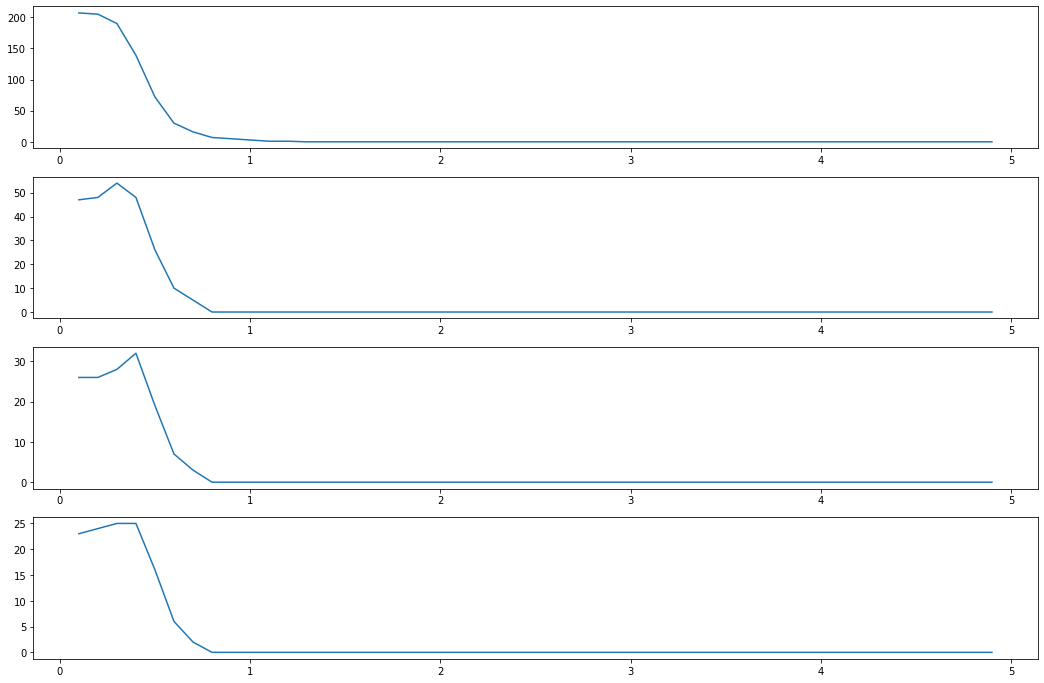

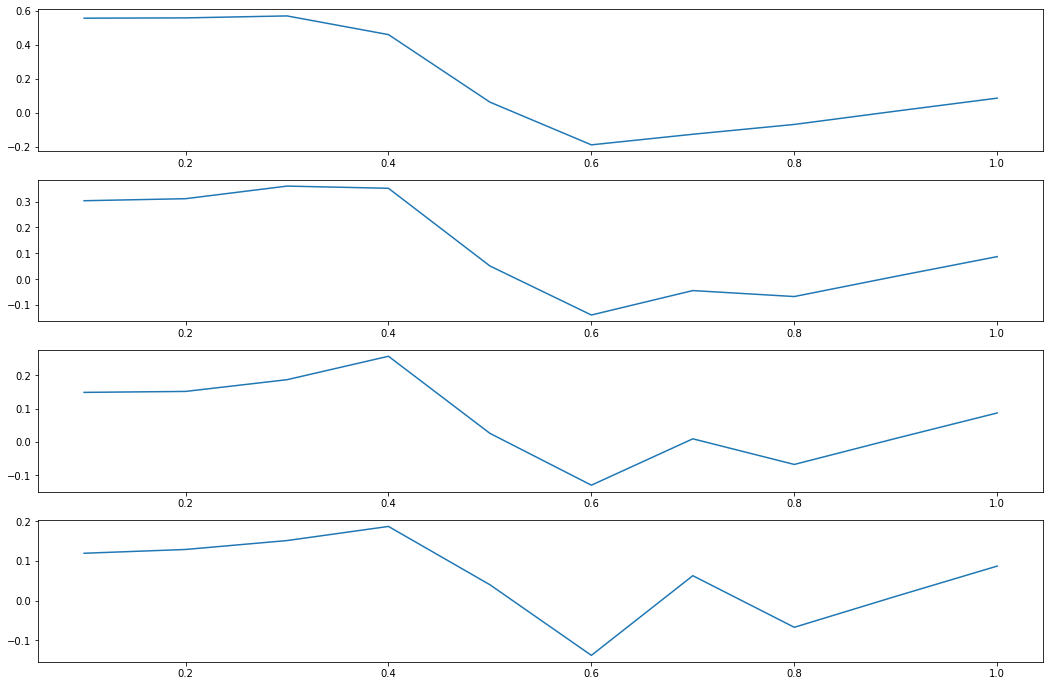

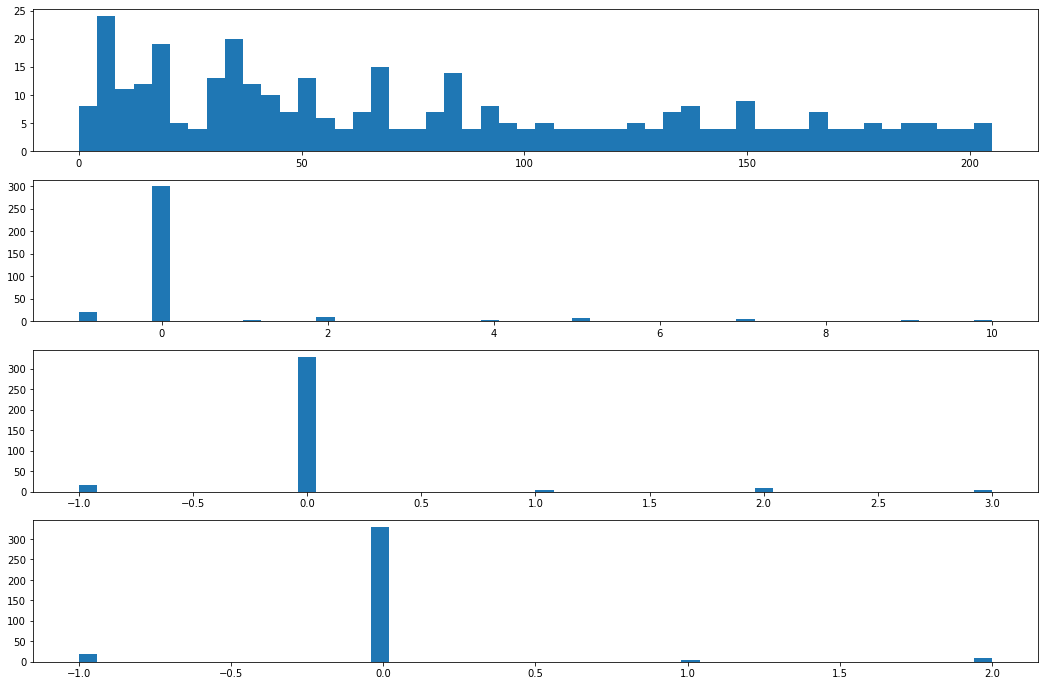

In [806]:
maxs = {}
sils = {}
labels = []
fig, axs = plt.subplots(4, 1, figsize=(18, 12))
fig, axs_s = plt.subplots(4, 1, figsize=(18, 12))
# Varying min_samples
for s in range (1,5):
    # Varying eps
    for i in range(1, 50):
        db = DBSCAN(eps=i/10, min_samples=s).fit(features_df)
        labels = db.labels_
        maxs[i/10] = max(labels)
        if max(labels) > 1:
            silh = silhouette_score(features_df, labels)
            sils[i/10] = silh

        if (i > 34) and (i < 40):
            print('min_samples = ' + str(s) +  ' - Eps = ' + str(i/10) + ' - Labels: ' + str(max(db.labels_)) + ' - Silhouett: ' + str(silh))

    names = list(maxs.keys())
    values = list(maxs.values())
    axs[s-1].plot(maxs.keys(), maxs.values())
    axs_s[s-1].plot(sils.keys(), sils.values())
    
fig, axs_f = plt.subplots(4, 1, figsize=(18, 12))

labels_1 = DBSCAN(eps=0.2, min_samples=1).fit(features_df).labels_
labels_2 = DBSCAN(eps=0.6, min_samples=2).fit(features_df).labels_
labels_3 = DBSCAN(eps=0.7, min_samples=3).fit(features_df).labels_
labels_4 = DBSCAN(eps=0.7, min_samples=4).fit(features_df).labels_

axs_f[0].hist(labels_1, bins=50)
axs_f[1].hist(labels_2, bins=50)
axs_f[2].hist(labels_3, bins=50)
axs_f[3].hist(labels_4, bins=50)

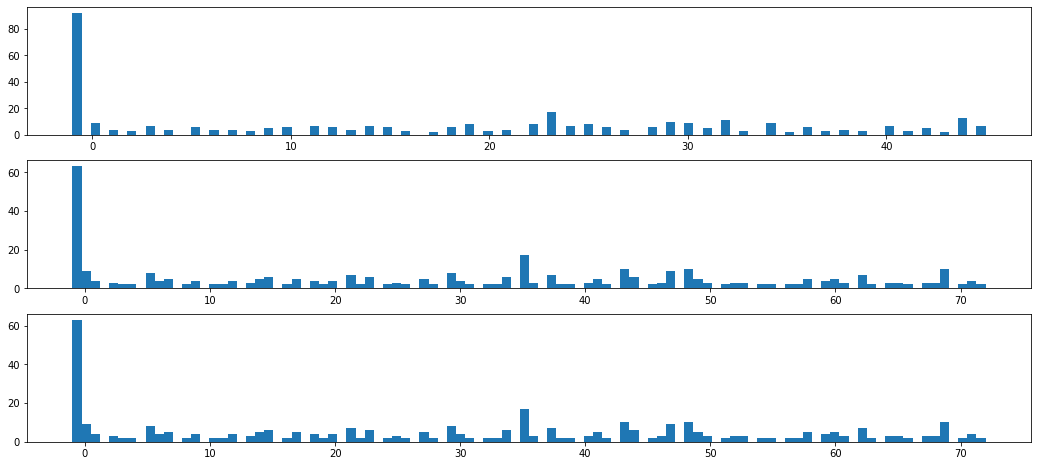

In [817]:
hdbs1 = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=None, metric='euclidean', \
                       algorithm='generic', leaf_size=20, prediction_data=True).fit(features_df)
hdbs2 = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1, metric='euclidean', \
                       algorithm='generic', leaf_size=20, prediction_data=True).fit(features_df)
hdbs3 = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1, metric='manhattan', \
                       algorithm='generic', leaf_size=80, prediction_data=True).fit(features_df)

fig, axs = plt.subplots(3, 1, figsize=(18, 8))
fig1 = axs[0].hist(hdbs1.labels_, bins=100)
fig2 = axs[1].hist(hdbs2.labels_, bins=100)
fig3 = axs[2].hist(hdbs3.labels_, bins=100)

In [818]:
silh1 = silhouette_score(sim_matrix, hdbs1.labels_)
silh2 = silhouette_score(sim_matrix, hdbs2.labels_)
silh3 = silhouette_score(sim_matrix, hdbs3.labels_)
print('Silhouette score for HDBS 1: ' + str(silh1))
print('Silhouette score for HDBS 2: ' + str(silh2))
print('Silhouette score for HDBS 3: ' + str(silh3))

Silhouette score for HDBS 1: 0.182999050414713
Silhouette score for HDBS 2: 0.32098072918032183
Silhouette score for HDBS 3: 0.32098072918032183


In [19]:
def build_model(df, eps, min_samples):
    # Extract the numerical value columns as prepared
    exp_df = df[['keyword_weights', 'entities_weight', 'sent_title', 'sent_text']]
    # Spread the arrays into columnar form
    exp = [pd.DataFrame(exp_df[col].tolist()).add_prefix(col) for col in exp_df.columns]
    exp_df = pd.concat([exp[0], exp[1], exp[2], exp[3]], axis= 1)
    exp_df = exp_df.fillna(0)
    # Normalise
    features_df = MinMaxScaler().fit_transform(exp_df)
    # Also, create the similarity matrix for model variation (hdbscan)
    #sim_matrix = linear_kernel(features_df, features_df)
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(features_df)
    
    return(features_df, db)

In [21]:
def save_hdbscan_model(model):
    # Serialize hdbscan model
    with open('hdbscan_model_r1_1.pickle', 'wb') as handle:
        pickle.dump(your_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return model

In [22]:
def get_hdbscan_model(file_path):
    # Deserialize hdbscan model
    with open('hdbscan_model_r1_1.pickle', 'rb') as handle:
        hdbscan_model = pickle.load(handle)
    return hdbscan_model

In [23]:
def predict(hdbs, new_data):
    labels, membership_strengths = hdbscan.approximate_predict(hdbs, new_data)
    return(labels, membership_strengths)

## Pipeline

In [ ]:
def nlp_pipeline(dataset_path):
    ''' All in one go: Preprocess raw articles texts, 
            visualise + describe corpus, vectorise, add 
            entities + sentiments, build hdbscan model
    '''
    df = preprocess_data(dataset_path)
    df = build_corpus(df)
    visualise_corpus(prep_data)
    descriptive_statistics(titles_merged, text_merged, title_corpus, text_corpus)
    df['weights'] = get_tfidf(df['merged_corpus'] )
    df, weights_df = add_keywords(df, 10)
    get_named_entities(df, vectorizer, weights)
    df = get_named_entities(df, weights_df)
    df = add_sentiments(df)
    return df
# TEST
df = nlp_pipeline(dir_path + file_name)
df.head()